# Beyond Linear: Going Hierarchical
All nice and well but linear models with only one predictor can be a bit boring, right? Also, most people know that size is not the only factor determining the rental price. If you've lived in Berlin for a while, you know that certain areas are much more expensive than others.

Unfortunately, this data set doesn't contain the coordinates for each flat nor the exact address. But for each flat we have a ZIP code (the PLZ).
We will now extend our model to incorporate the location by using the ZIP code. We do so by training one linear model per ZIP code.

In [150]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pymc3 as pm
import theano

import sys
sys.path.append('../src/')
from utils import standardize_area, destandardize_area

berlin = pd.read_csv("../data/berlin.csv", index_col=0, dtype={"geo_plz":str})

../src/utils.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  berlin["livingSpace_s"] = (berlin["livingSpace"] - berlin["livingSpace"].mean()) / np.std(berlin["livingSpace"])
../src/utils.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  berlin["totalRent_s"] = berlin["totalRent"] / 100


In [151]:
plt.style.use("corrie")

One model per zip code works well if a zip code has many observations:

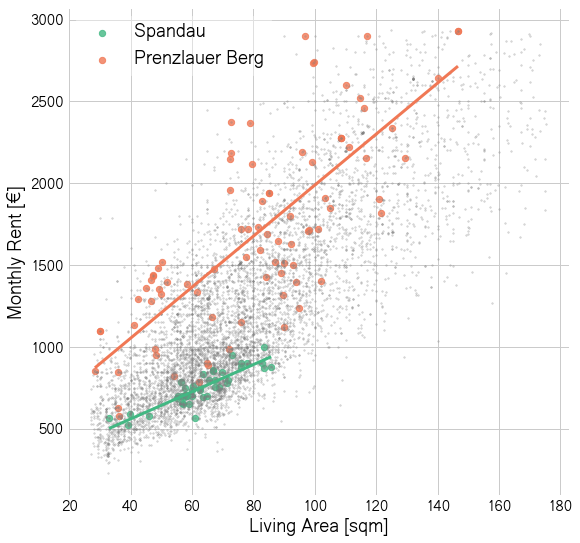

In [152]:
sns.regplot(x=berlin["livingSpace"][berlin.geo_plz == "13583"], y=berlin["totalRent"][berlin.geo_plz == "13583"], 
            color="#42b883", ci=0, scatter_kws={"s": 40}, label="Spandau")
sns.regplot(x=berlin["livingSpace"][berlin.geo_plz == "10405"], y=berlin["totalRent"][berlin.geo_plz == "10405"], 
            color="#f07855",  ci=0, scatter_kws={"s": 40}, label="Prenzlauer Berg")

plt.scatter(berlin["livingSpace"], berlin["totalRent"], s=3, c="gray", alpha=0.3)
plt.ylabel("Monthly Rent [€]")
plt.xlabel("Living Area [sqm]")
plt.legend()
plt.show()

If a zip code has only a handful or less observations, it is a bit more difficult. In this zip code, we only have two observations and a model fit on these two points would result in a negative slope which doesn't make much sense. In cases where we have little data, we would prefer the model to be closer to a model fit on all data, as we did before. Since even in Blankenburg, in general, bigger flats should be more expensive.

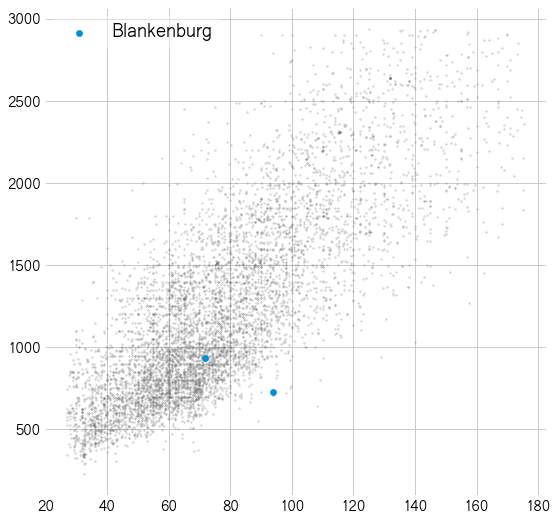

In [153]:
plt.scatter(berlin["livingSpace"], berlin["totalRent"], s=3, c="gray", alpha=0.3)
plt.scatter(berlin["livingSpace"][berlin.geo_plz == "13129"], 
            berlin["totalRent"][berlin.geo_plz == "13129"], s=40, label="Blankenburg")
plt.legend()
plt.show()

We can achieve this by saying that for each linear model (one for each zip code), the parameters determining the slope and intercept of this model come from a common distribution. So all slope parameters for example would come from a Normal distribution centered around some value close to 4.4 (the slope parameter we obtained in our last model) but the slope for Prenzlauer Berg would be higher than average while Spandau would be lower than average and places like Blankenburg would stay close to the mean (and also have higher uncertainty).

Before, our model looked like this:

$$\begin{align*}
\text{rent} &\sim \text{Normal}(\mu, \sigma) \\
\mu &= \alpha + \beta \text{area} \\
\\
\alpha &\sim \text{Normal}(0, 10) \\
\beta &\sim \text{Normal}(0, 5) \\
\\
\sigma &\sim \text{HalfNormal}(5) 
\end{align*}$$

We know extend this as follows:
$$\begin{align*}
\text{rent} &\sim \text{Normal}(\mu, \sigma) \\
\mu &= \alpha_{[\text{ZIP}]} + \beta_{[\text{ZIP}]} \text{area} \\
\\
\alpha_{[\text{ZIP}]} &\sim \text{Normal}(\mu_{\alpha}, \sigma_{\alpha}) \\
\beta_{[\text{ZIP}]} &\sim \text{Normal}(\mu_{\beta}, \sigma_{\beta}) \\
\\
\mu_{\alpha} &\sim \text{Normal}(0, 10) \\
\mu_{\beta} &\sim \text{Normal}(0, 5) \\
\\
\sigma, \sigma_{\alpha}, \sigma_{\beta} &\sim \text{HalfNormal}(5) 
\end{align*}$$

This looks like an awful lot more formula but the most important changes are only in the second, third and fourth line, the lines below are mostly repeating priors from above.

In the second line, we use a linear model similar to above, but with different $\alpha$ and $\beta$ for each ZIP code. As before, we need to define priors for these two parameters. Only unlike above, we now put so called hyperpriors on the parameters of these priors. $\mu_{\alpha}$ is now the expected mean for the intercepts of each ZIP code and $\sigma_{\alpha}$ determines how much of a difference there can be between the intercept in Spandau and the intercept in Prenzlauer Berg.

Don't worry if so many formulas are not your cup of tea, we now gonna look at the code for the model. Before writing the model however, we need to map the zip codes to an index variable:

In [154]:
berlin.zip = berlin.geo_plz.map(str.strip)
zip_codes = np.sort(berlin.zip.unique())
num_zip_codes = len(zip_codes)
zip_lookup = dict(zip(zip_codes, range(num_zip_codes)))
berlin["zip_code"] = berlin.zip.replace(zip_lookup).values

/home/corrie/.local/share/virtualenvs/PyLadies-Bayesian-Tutorial-HLPPdyhP/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """Entry point for launching an IPython kernel.


And a small helper function to map from ZIP string to ZIP code:

In [80]:
def map_zip_codes(zip_strings, zip_lookup=zip_lookup):
    return pd.Series(zip_strings).replace(zip_lookup).values

In [70]:
zips = berlin["zip_code"].values

with pm.Model() as hier_model:
    
    mu_alpha = pm.Normal("mu_alpha", mu=0, sigma=10)
    sigma_alpha = pm.HalfNormal("sigma_alpha", sigma=5)
    
    mu_beta = pm.Normal("mu_beta", mu=0, sigma=5)
    sigma_beta = pm.HalfNormal("sigma_beta", sigma=5)
    
    alpha = pm.Normal("alpha", mu=mu_alpha, sd=sigma_alpha, 
                      shape=num_zip_codes)
    
    beta = pm.Normal("beta", mu=mu_beta, sd=sigma_beta, 
                     shape=num_zip_codes)
    

    sigma = pm.HalfNormal("sigma", sigma=5)
    
    mu = alpha[zips] + beta[zips]*berlin["livingSpace_s"]
    
    rent = pm.Normal("rent", mu=mu, sd=sigma, observed=berlin["totalRent_s"])
    
    trace = pm.sample(random_seed=2020, chains=4, 
                      draws=1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sigma, beta, alpha, sigma_beta, mu_beta, sigma_alpha, mu_alpha]
100%|██████████| 4000/4000 [00:06<00:00, 603.28it/s]


We will need to do the convergency checks again. For this, we first collect the model artifacts in an ArviZ Data object:

In [87]:
import arviz as az
pm_data = az.from_pymc3(model=hier_model, trace=trace  )

One thing where the ArviZ Data object is very useful, is for dealing with high-dimensional model artificats. With hierararchical models such as this one, we get one parameter per level (here the ZIP codes) and 4000 samples per parameter, coming from four chains (at least in the beginning, we want to keep the samples of each chain separated). ArviZ makes it easier to keep track of all the different dimensions and coordinates:

In [89]:
pm_data.posterior

<xarray.Dataset>
Dimensions:      (alpha_dim_0: 208, beta_dim_0: 208, chain: 4, draw: 1000)
Coordinates:
  * chain        (chain) int64 0 1 2 3
  * draw         (draw) int64 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
  * alpha_dim_0  (alpha_dim_0) int64 0 1 2 3 4 5 6 ... 202 203 204 205 206 207
  * beta_dim_0   (beta_dim_0) int64 0 1 2 3 4 5 6 ... 202 203 204 205 206 207
Data variables:
    mu_alpha     (chain, draw) float64 11.95 11.69 11.92 ... 11.62 11.69 11.85
    mu_beta      (chain, draw) float64 3.766 3.902 3.905 ... 3.895 3.917 3.914
    alpha        (chain, draw, alpha_dim_0) float64 11.29 15.98 ... 12.72 9.833
    beta         (chain, draw, beta_dim_0) float64 4.367 4.522 ... 4.902 2.345
    sigma_alpha  (chain, draw) float64 2.094 2.225 2.004 ... 2.24 2.245 2.217
    sigma_beta   (chain, draw) float64 0.6346 0.6425 0.5459 ... 0.6971 0.7499
    sigma        (chain, draw) float64 2.309 2.277 2.307 ... 2.278 2.263 2.31
Attributes:
    created_at:                 2020-02-07T14:41:39.534563
    inference_library:          pymc3
    inference_library_version:  3.8

There are the dimensions `alpha_dim_0` and `beta_dim_0` that represent the ZIP codes. We have 208 ZIP codes and since we mapped them to an index, the coordinates for these dimensions are simply the integers from 0 to 207. But we can give them meaningful names by providing ArviZ with the original ZIP code strings:

In [90]:
pm_data = az.from_pymc3(model=hier_model, trace=trace,
                        # create a new coordinate
                        coords={'zip_code': zip_codes},
                        # this coordinate is used by the dimension alpha and beta
                        dims={"alpha": ["zip_code"], "beta": ["zip_code"]} )

In [91]:
pm_data.posterior

<xarray.Dataset>
Dimensions:      (chain: 4, draw: 1000, zip_code: 208)
Coordinates:
  * chain        (chain) int64 0 1 2 3
  * draw         (draw) int64 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
  * zip_code     (zip_code) object '10017' '10115' '10117' ... '14199' '19437'
Data variables:
    mu_alpha     (chain, draw) float64 11.95 11.69 11.92 ... 11.62 11.69 11.85
    mu_beta      (chain, draw) float64 3.766 3.902 3.905 ... 3.895 3.917 3.914
    alpha        (chain, draw, zip_code) float64 11.29 15.98 ... 12.72 9.833
    beta         (chain, draw, zip_code) float64 4.367 4.522 ... 4.902 2.345
    sigma_alpha  (chain, draw) float64 2.094 2.225 2.004 ... 2.24 2.245 2.217
    sigma_beta   (chain, draw) float64 0.6346 0.6425 0.5459 ... 0.6971 0.7499
    sigma        (chain, draw) float64 2.309 2.277 2.307 ... 2.278 2.263 2.31
Attributes:
    created_at:                 2020-02-07T14:44:57.166242
    inference_library:          pymc3
    inference_library_version:  3.8

Next, we'll check the trace plots. Remember, ArviZ has a function for this. Only problem: we know have many many alpha and beta parameters, one each for each ZIP code. This is way too much to plot! Use the function parameter `var_names` to only select the parameters from the model that don't use ZIP code as index.

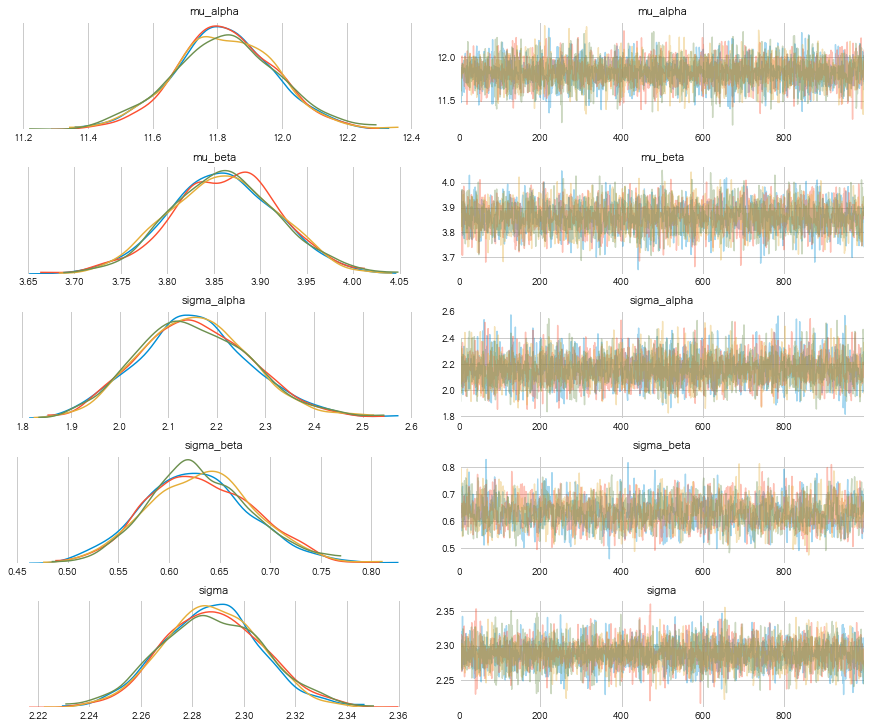

In [82]:
az.plot_trace(pm_data, 
              var_names = ["mu_alpha", "mu_beta", "sigma_alpha", "sigma_beta", "sigma"]
            )
plt.show()

Next, we'll check the three different summary/diagnostic statistics. There were R_hat, MCSE (Monte Carlo Standard Error), and ESS (Effective Sample Size). You can get the summary table using ArviZ again:

In [147]:
az.summary(pm_data, round_to=4)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu_alpha,11.8234,0.1571,11.5323,12.1314,0.0018,0.0013,7859.0572,7859.0572,7892.2225,3100.8661,1.0003
mu_beta,3.8611,0.0580,3.7578,3.9755,0.0008,0.0006,4689.7530,4688.0493,4680.3076,3474.1213,1.0004
alpha[0],12.8173,1.5358,9.9050,15.6645,0.0151,0.0110,10339.6602,9820.4079,10320.8216,2916.2788,1.0015
alpha[1],15.8415,0.1850,15.4922,16.1879,0.0021,0.0015,7563.8274,7546.7237,7584.2643,3357.0032,1.0002
alpha[2],17.0136,0.2433,16.5808,17.4874,0.0030,0.0021,6577.9308,6577.9308,6543.7585,3094.5670,0.9998
...,...,...,...,...,...,...,...,...,...,...,...
beta[206],4.8329,0.2696,4.3454,5.3519,0.0027,0.0019,9692.8373,9692.8373,9736.6014,2450.2929,1.0021
beta[207],3.8103,0.6401,2.6701,5.0521,0.0067,0.0050,9133.5445,8319.5304,9106.1756,2898.9005,1.0004
sigma_alpha,2.1571,0.1174,1.9340,2.3729,0.0015,0.0010,6322.6749,6262.6155,6330.0007,3600.9033,0.9999
sigma_beta,0.6307,0.0520,0.5347,0.7290,0.0012,0.0008,2009.4435,2009.4435,2001.6692,2454.5415,1.0005


Unfortunately, since we have so many parameters, we can't check them easily by hand. What we can do instead, is to plot a histogram for each of the diagnostics:

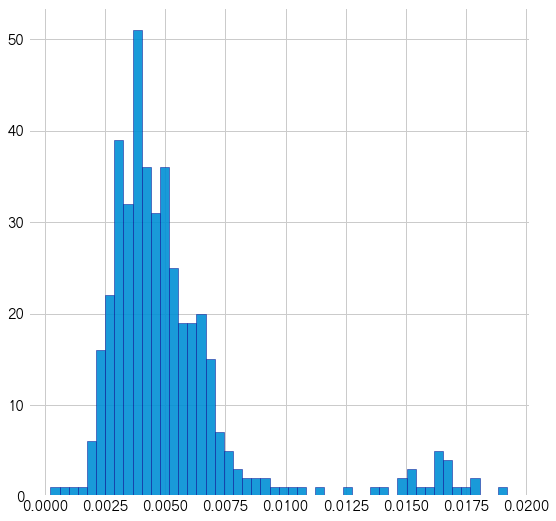

In [95]:
summ = az.summary(pm_data, round_to=5)
plt.hist(summ["mcse_mean"], bins=50, alpha=0.9, ec="darkblue")
plt.title("MCSE Mean")
plt.show()

Check for yourself the Rhat and ESS diagnostics:

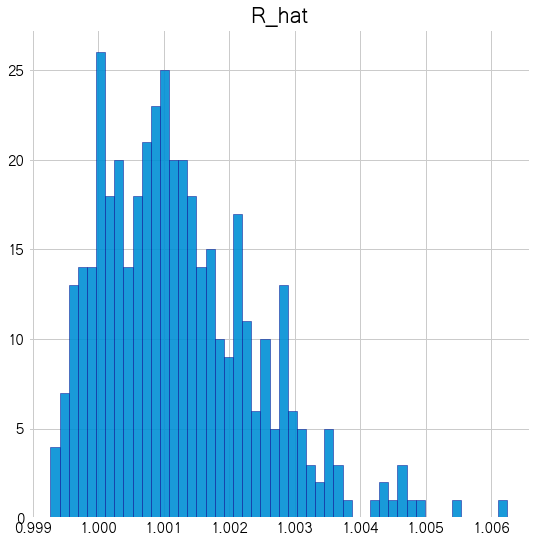

In [96]:
summ = az.summary(pm_data, round_to=5)
plt.hist(summ["r_hat"], bins=50, alpha=0.9, ec="darkblue")
plt.title("R_hat")
plt.show()

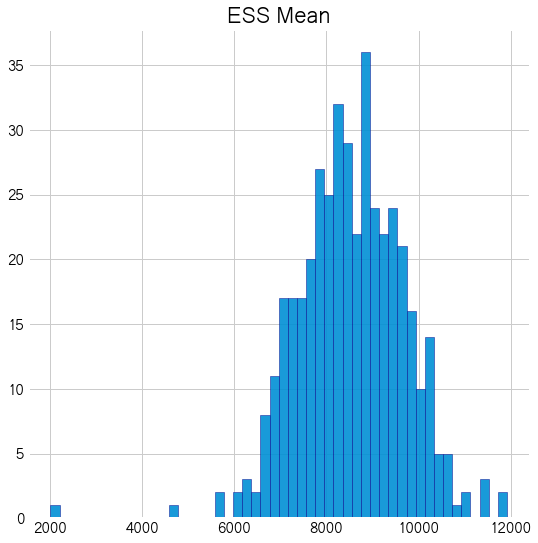

In [97]:
summ = az.summary(pm_data, round_to=5)
plt.hist(summ["ess_mean"], bins=50, alpha=0.9, ec="darkblue")
plt.title("ESS Mean")
plt.show()

Before, we checked how good our model fit the data by comparing the plot of the linear model to our data. Since we now have a collection of linear models, this would be rather difficult. What we can do instead is a so called posterior-predictive check. We compare the predicted distribution of outcomes to the actual distribution of outcomes.

In [100]:
with hier_model:
    posterior_pred = pm.sample_posterior_predictive(trace=trace)

100%|██████████| 4000/4000 [00:09<00:00, 404.27it/s]


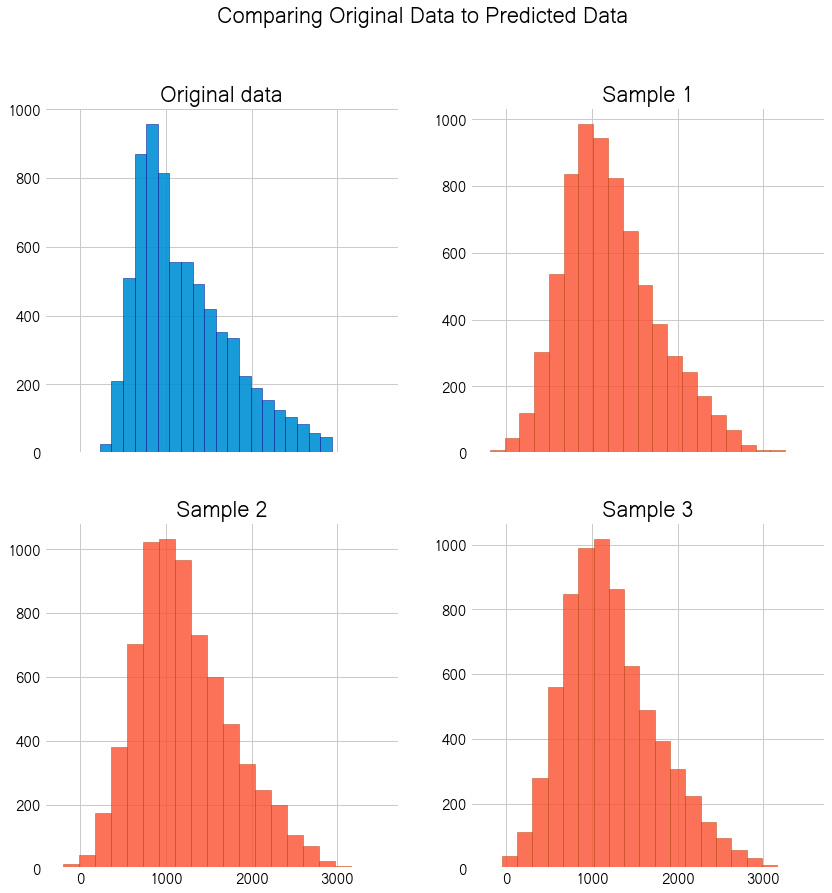

In [146]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(14,14), sharex=True)
ax = ax.ravel()
ax[0].hist(berlin["totalRent"], ec="darkblue", alpha=0.9, bins=20)
ax[0].set_title("Original data")
sample_nums = np.random.choice(posterior_pred["rent"].shape[0], size=3, replace=False)
for i, samp in enumerate(sample_nums):
    ax[i+1].hist(posterior_pred["rent"][samp]*100, ec="#a93900",color="#fc4f30", alpha=0.8, bins=20)
    ax[i+1].set_title(f"Sample {i+1}")
plt.suptitle("Comparing Original Data to Predicted Data")
plt.show()

To predict the rental prices on new flats, we can proceed similar as before. 
Unfortunately, because of an still unclosed issue, we can't use the PyMC data container to update the ZIP code indices but need to use a shared theano variable. However, both types are updated in a similar fashion.

In [ ]:
zips = theano.shared(berlin["zip_code"].values)
# idx variables cannnot used with pm.Data() so far, because of bug
# see here: https://discourse.pymc.io/t/integer-values-with-pm-data/3776
# and here: https://github.com/pymc-devs/pymc3/issues/3493


with pm.Model() as hier_model:
    area = pm.Data("area", berlin["livingSpace_s"])
    #zips = pm.Data("zips", d["zip_code"].values)
    
    mu_alpha = pm.Normal("mu_alpha", mu=0, sigma=10)
    sigma_alpha = pm.HalfNormal("sigma_alpha", sigma=5)
    
    mu_beta = pm.Normal("mu_beta", mu=0, sigma=5)
    sigma_beta = pm.HalfNormal("sigma_beta", sigma=5)
    
    alpha = pm.Normal("alpha", mu=mu_alpha, sd=sigma_alpha, 
                      shape=num_zip_codes)
    
    beta = pm.Normal("beta", mu=mu_beta, sd=sigma_beta, 
                     shape=num_zip_codes)
    

    sigma = pm.HalfNormal("sigma", sigma=5)
    
    mu = alpha[zips] + beta[zips]*area
    
    rent = pm.Normal("rent", mu=mu, sd=sigma, observed=berlin["totalRent_s"])
    
    trace = pm.sample(random_seed=2020, chains=4, 
                      draws=1000, tune=1000)

Feel free to change the area and ZIP code data to for example your own flat.

In [157]:
more_flats = pd.DataFrame({"area": standardize_area(np.array([100, 240, 74])), 
                           "zip_code": ["10243", "10179", "12047"]})

more_flats["zip"] = map_zip_codes(more_flats["zip_code"])

In [159]:
with hier_model:
    zips.set_value(more_flats["zip"])
    pm.set_data({"area": more_flats["area"]})
    post_pred = pm.sample_posterior_predictive(trace, samples=1000)

/home/corrie/.local/share/virtualenvs/PyLadies-Bayesian-Tutorial-HLPPdyhP/lib/python3.7/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 1000/1000 [00:03<00:00, 288.76it/s]


As before, we can now plot this as a histogram:

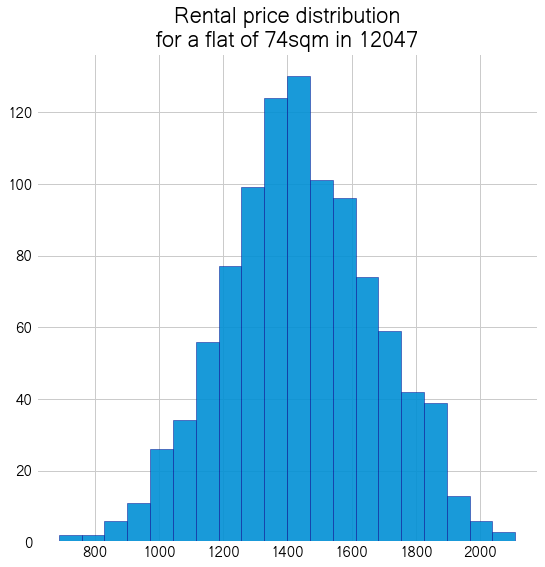

In [167]:
y_pred = post_pred["rent"][:,2]*100

plt.hist(y_pred, ec="darkblue", alpha=0.9, bins=20)
plt.title("Rental price distribution\nfor a flat of 74sqm in 12047")
plt.show()

Or ask for the probability that your flat would have a rent lower than your own rent:

In [168]:
np.mean(y_pred < 900)

0.01